In [828]:
import scipy, sys
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants
sys.path.append("/Users/alex/Desktop/Fabry-Perot/modelling")
sys.path.append(r"C:\Users\da1qu1r1\Dropbox\Arbeit\Fabry-Perot\modelling")
sys.path.append(r"C:\Users\ge85rek\Desktop\Fabry-Perot\modelling")
import read_csv, T_and_R

In [829]:
def calculate_m(min_frequenz_array):
    m_array = []
    for i in range(0,len(min_frequenz_array)-1):
        m_array.append(min_frequenz_array[i+1]/(min_frequenz_array[i]-min_frequenz_array[i+1]))
    return m_array

In [830]:
def länge(m,n,f):
    lam = scipy.constants.c/f
    return m * lam / (2 * n)

In [831]:
data = read_csv.read_csv(r"C:\Users\ge85rek\Desktop\Fabry-Perot\data\InGaN_FTIR.csv")
# von cm zu m 
frequenz = scipy.constants.c * np.array(data[0]) * 100
frequenz

array([2.39815071e+14, 2.39800616e+14, 2.39786160e+14, ...,
       1.20124367e+13, 1.19979813e+13, 1.19835259e+13])

In [832]:
wavelength = scipy.constants.c/frequenz
wavelength

array([1.25009849e-06, 1.25017385e-06, 1.25024921e-06, ...,
       2.49568399e-05, 2.49869084e-05, 2.50170494e-05])

In [833]:
# return index of a sorted list wherelist[index] is a specific value
def find_nearest(array, value, cutup = None):
    array = np.asarray(array)
    end = (np.abs(array - value)).argmin()
    return end

In [834]:
def flatten(cutoff, data, N = 1200, cutup = None):
    smooth = np.convolve(data, np.ones(N)/N, mode='same')
    if cutup is not None:
        return smooth[cutup:cutoff], data[cutup:cutoff]-smooth[cutup:cutoff]
    else:
        return smooth[:cutoff], data[:cutoff]-smooth[:cutoff]

In [835]:
cutoff = find_nearest(frequenz, 0.6e14)
smooth, smoothed_out = flatten(cutoff, data[1])
frequenz_s = frequenz[:cutoff]

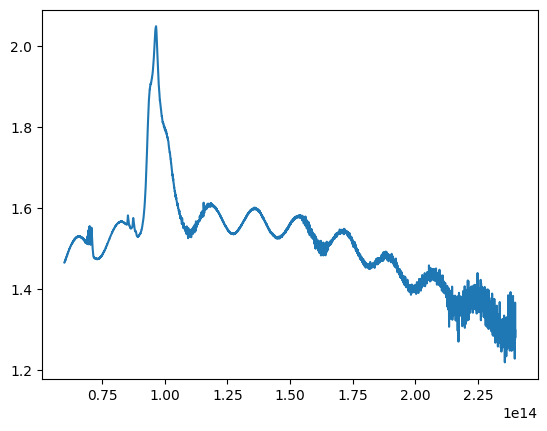

In [836]:
plt.plot(frequenz_s,data[3][:cutoff])

## Calculation for J14028 at room temperature (20deg)

In [837]:
room_smooth, room_smoothed_out = flatten(cutoff, data[11])

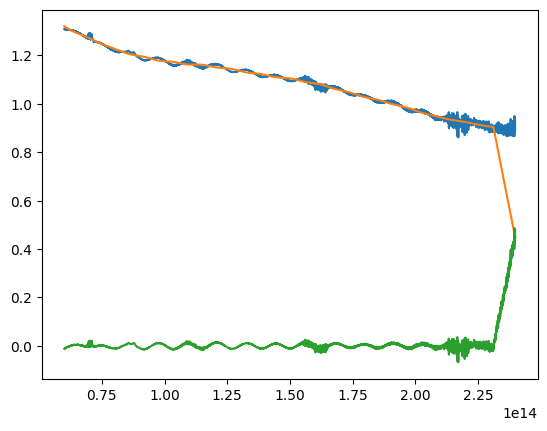

In [838]:
plt.plot(frequenz_s,data[11][:cutoff])
plt.plot(frequenz_s,room_smooth[:cutoff])
plt.plot(frequenz_s,room_smoothed_out)

In [839]:
minima_index_calc_room = scipy.signal.argrelmin(room_smoothed_out, order = 500)
minima_frequenz_room = []
minima_absorption_room = []
for minimum in minima_index_calc_room[0]:
    minima_frequenz_room.append(frequenz[minimum])
    minima_absorption_room.append(room_smoothed_out[minimum])
m_array_room = calculate_m(minima_frequenz_room)
m_array_room = m_array_room[3:]
minima_frequenz_room = minima_frequenz_room[3:]
minima_absorption_room = minima_absorption_room[3:]
m_array_room

[15.434447301614046,
 14.414634155886741,
 12.38379022568226,
 12.337612296752692,
 10.523980839666178,
 10.124207839998222,
 8.475682082499548,
 7.820987671247991,
 7.153153149762617]

In [840]:
m_array_room_clean = np.arange(7,16,1)[::-1] #very weird
m_array_room_clean

array([15, 14, 13, 12, 11, 10,  9,  8,  7])

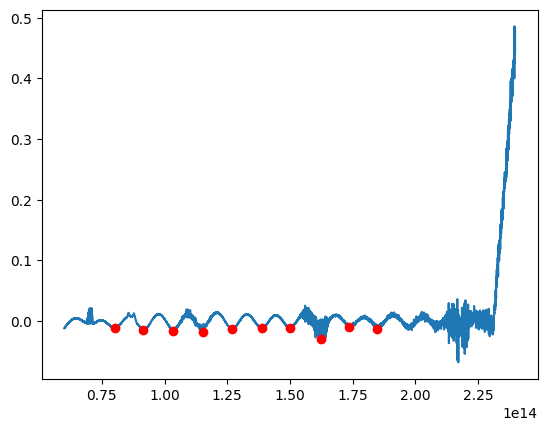

In [841]:
plt.plot(frequenz_s,room_smoothed_out)
plt.plot(minima_frequenz_room,minima_absorption_room,'ro')

### modelling the refractive index

In [842]:
def polynomial(x,a0,a1,a2,a3):
    return a0 + a1*x + a2*x**2 + a3*x**3

def refractive_index(m,L,f):
    wavelength = scipy.constants.c/f
    n = (m * wavelength) / (2 * L)
    return n 

In [843]:
m_array_room_clean

array([15, 14, 13, 12, 11, 10,  9,  8,  7])

In [844]:
minima_frequenz_room

[184826732875360.0,
 173580432377185.78,
 162319676486271.78,
 150191596641236.9,
 138930840720343.62,
 126875037898966.48,
 115469727990716.27,
 103283826544742.78,
 91574953299018.11,
 80343108193583.73]

In [845]:
n_array_minima_room = []
for i in range(len(m_array_room_clean)):
    n_array_minima_room.append(refractive_index(m_array_room_clean[i],4.6e-6,minima_frequenz_room[i]))
n_array_minima_room

[2.644596068343528,
 2.628210496425671,
 2.609786975792324,
 2.603565376587802,
 2.5800427196144318,
 2.56836469007241,
 2.5398451676941094,
 2.5240069295855574,
 2.4908880535171276]

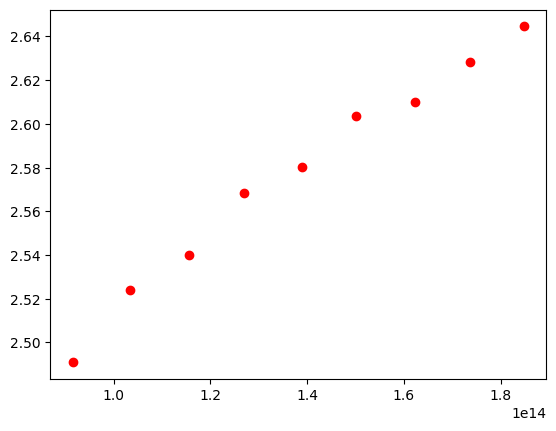

In [846]:
plt.plot(minima_frequenz_room[:-1],n_array_minima_room,'ro')

In [847]:
params_J14, cov = scipy.optimize.curve_fit(polynomial, minima_frequenz_room[:-1], n_array_minima_room)

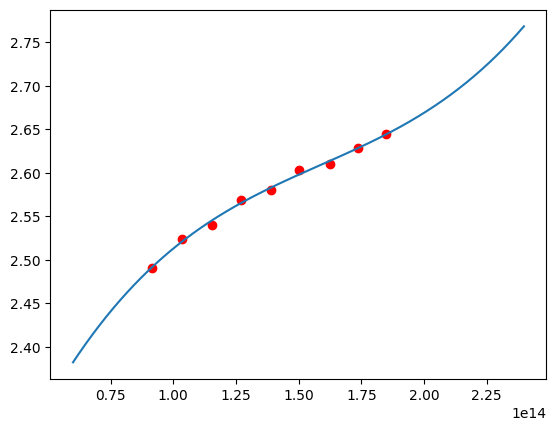

In [848]:
plt.plot(minima_frequenz_room[:-1],n_array_minima_room,'ro')
plt.plot(frequenz_s, polynomial(np.array(frequenz_s), *params_J14))

In [849]:
def optdick_total(f):
    return 4.6e-6 * polynomial(np.array(f), *params_J14)

In [850]:
params_STINS = np.array([ 7.62392205e-01,  1.95423832e-14, -9.96420756e-29,  1.83173412e-43])

In [851]:
def optdick_STINS(f): 
    return 3.5e-6 * polynomial(np.array(f), *params_STINS)

In [852]:
def optdick_toppart(f):
    return optdick_total(f) - optdick_STINS(f)

In [853]:
def dispersion_toppart(f):
    return optdick_toppart(f) / 1.1e-6

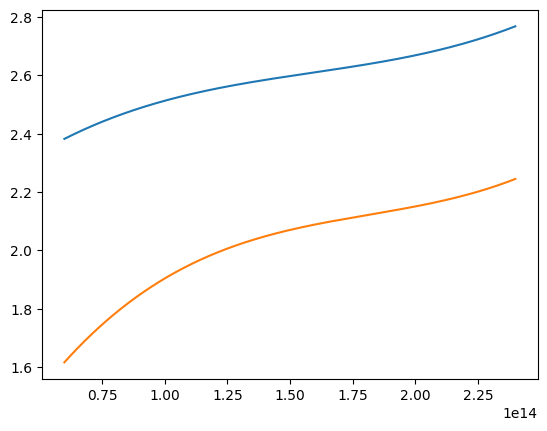

In [854]:
plt.plot(frequenz_s,polynomial(np.array(frequenz_s), *params_J14))
plt.plot(frequenz_s,polynomial(np.array(frequenz_s), *params_STINS))

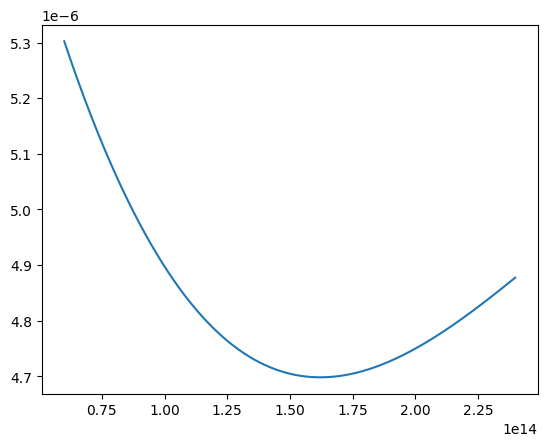

In [855]:
plt.plot(frequenz_s, optdick_toppart(frequenz_s))

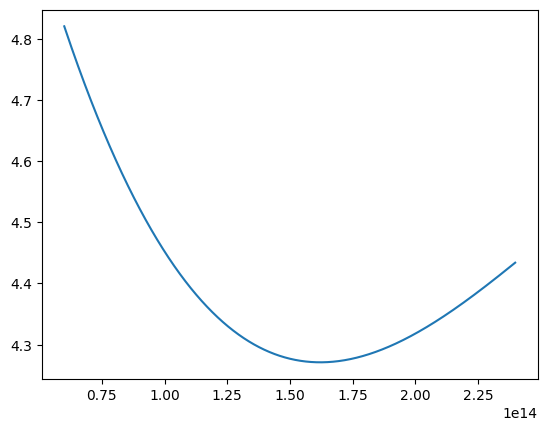

In [856]:
plt.plot(frequenz_s, dispersion_toppart(frequenz_s))

In [857]:
L_array = []
for i in range(len(n_array_minima_room)):
    L_array.append(länge(m_array_room_clean[i],polynomial(minima_frequenz_room[i],*params_J14),minima_frequenz_room[i]))

In [858]:
L_array

[4.60094723348464e-06,
 4.6000024518921075e-06,
 4.593403987793253e-06,
 4.609806685023513e-06,
 4.594833334234971e-06,
 4.606001035435053e-06,
 4.589977579513733e-06,
 4.606445923411191e-06,
 4.5985818788512885e-06]

### Berechnen der Länge bei 90C

In [859]:
for i in range(len(n_array_minima_room)):
    print(n_array_minima_room[i]-polynomial(minima_frequenz_room[i], *params_J14))

0.0005444639597369516
1.4008880735438822e-06
-0.0037475882363233737
0.005538702017434005
-0.0029011320807708074
0.0033462535932340387
-0.005545865050465171
0.0035319106373825626
-0.000768145728580194


In [860]:
data90 = data[12]

In [861]:
cutoff = find_nearest(frequenz, 0.6e14)
cutup = find_nearest(frequenz, 1.8e14)

In [862]:
smooth90,smoothed_out90 = flatten(cutoff,data90,cutup = cutup)

In [863]:
frequenz_s_cut = frequenz[cutup:cutoff]

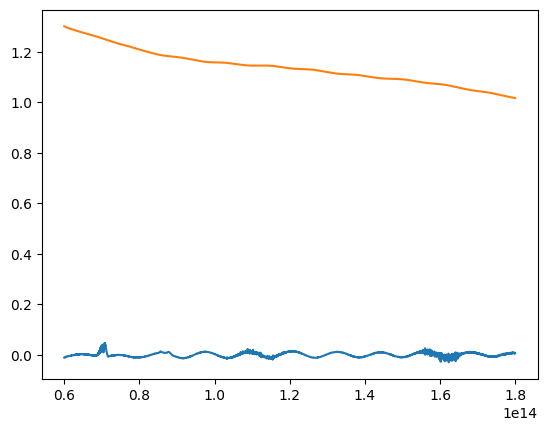

In [864]:
plt.plot(frequenz_s_cut,smoothed_out90)
plt.plot(frequenz_s_cut,smooth90)

In [865]:
minimum_index_90 = scipy.signal.argrelmin(smoothed_out90, order = 500)
minima_frequenz_90 = []
minma_absorption_90 = []
m_array_90 = []
for minimum in minimum_index_90[0]:
    minima_frequenz_90.append(frequenz_s_cut[minimum])
    minma_absorption_90.append(smoothed_out90[minimum])
m_array_90 = calculate_m(minima_frequenz_90)
m_array_90

[13.72738388124031,
 11.65952649849665,
 12.518954222368773,
 10.911691557797592,
 10.175796164188625,
 8.475682082499548,
 8.010088275796717,
 6.267734559634687]

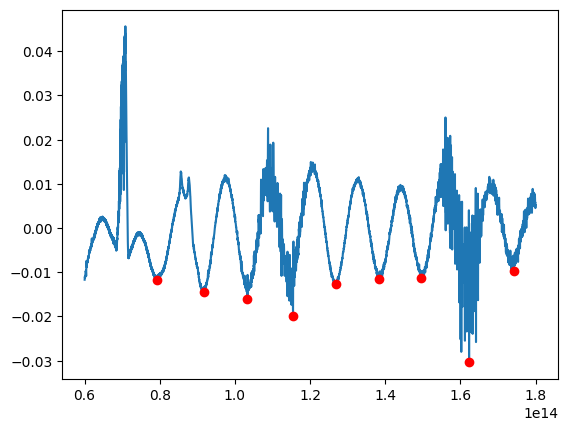

In [866]:
plt.plot(frequenz_s_cut,smoothed_out90)
plt.plot(minima_frequenz_90,minma_absorption_90,'ro')

In [867]:
m_array_90_clean = np.arange(7,15,1)[::-1]

In [868]:
n_array_minima_90 = []
for i in range(len(m_array_90_clean)):
    n_array_minima_90.append(polynomial(minima_frequenz_90[i], *params_J14))
n_array_minima_90

[2.6289675316646224,
 2.6135345640286474,
 2.5971262352166926,
 2.5822560472257443,
 2.564926312091186,
 2.5453910327445746,
 2.520475018948175,
 2.492317159643384]

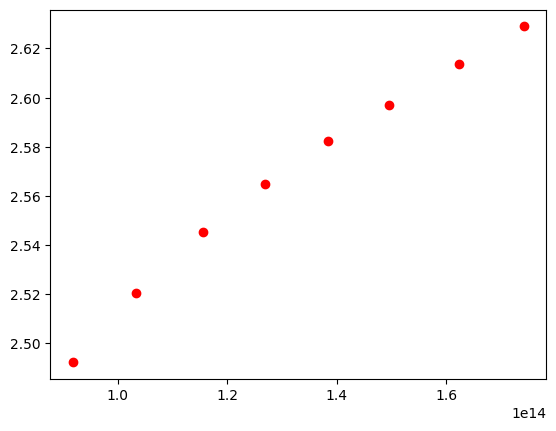

In [869]:
plt.plot(minima_frequenz_90[:-1],n_array_minima_90,'ro')

In [870]:
L_array_90 = []
for i in range(len(n_array_minima_90)):
    L_array_90.append(länge(m_array_90_clean[i],n_array_minima_90[i],minima_frequenz_90[i]))

In [871]:
L_array_90

[4.583788002072312e-06,
 4.593403987793253e-06,
 4.632807701656143e-06,
 4.612373999409545e-06,
 4.608266624903736e-06,
 4.589977579513733e-06,
 4.606445923411191e-06,
 4.585058315852244e-06]

### For -160C

In [872]:
data_160 = data[13]

In [873]:
cutoff = find_nearest(frequenz, 0.71e14)
cutup = find_nearest(frequenz, 1.55e14)
frequenz_s_cut = frequenz[cutup:cutoff]

In [874]:
smooth160,smoothed_out160 = flatten(cutoff,data_160,cutup = cutup)

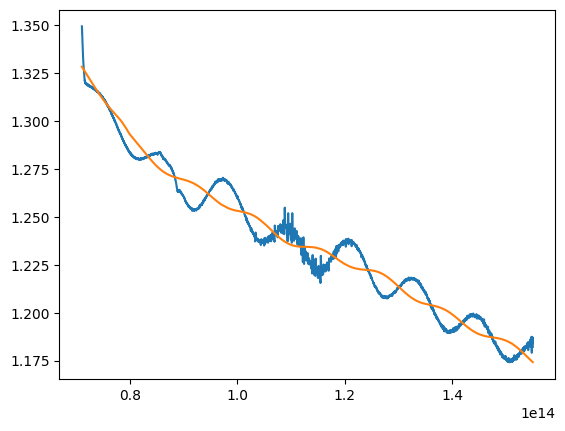

In [875]:
plt.plot(frequenz_s_cut,data_160[cutup:cutoff])
plt.plot(frequenz_s_cut,smooth160)

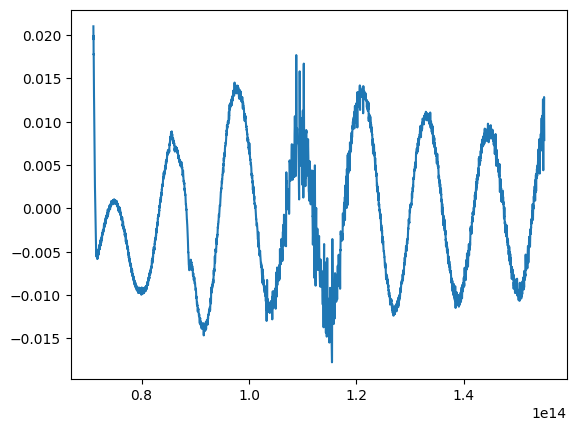

In [876]:
plt.plot(frequenz_s_cut,smoothed_out160)

In [877]:
minimum_index_160 = scipy.signal.argrelmin(smoothed_out160, order = 500)
minima_frequenz_160 = []
minma_absorption_160 = []
m_array_160 = []
for minimum in minimum_index_160[0]:
    minima_frequenz_160.append(frequenz_s_cut[minimum])
    minma_absorption_160.append(smoothed_out160[minimum])
m_array_160 = calculate_m(minima_frequenz_160)
m_array_160

[11.626213585720892,
 10.974999990278516,
 10.071878945764094,
 8.485748208800787,
 7.820987671247991,
 6.8793532251394796]

In [878]:
m_array_160_clean = np.arange(7,13,1)[::-1]

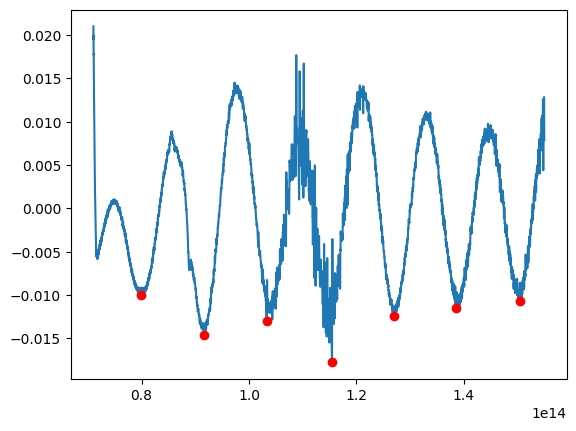

In [879]:
plt.plot(frequenz_s_cut,smoothed_out160)
plt.plot(minima_frequenz_160,minma_absorption_160,'ro')

In [880]:
n_array_minima_160 = []
for i in range(len(m_array_160_clean)):
    n_array_minima_160.append(polynomial(minima_frequenz_160[i], *params_J14))
n_array_minima_160

[2.598288805787778,
 2.582316859063425,
 2.565087485654897,
 2.5453641022629365,
 2.520475018948175,
 2.491656199245708]

In [881]:
L_array_160 = []
for i in range(len(n_array_minima_160)):
    L_array_160.append(länge(m_array_160_clean[i],n_array_minima_160[i],minima_frequenz_160[i]))

In [882]:
L_array_160

[4.6031391222162105e-06,
 4.610821038741291e-06,
 4.6043032858402695e-06,
 4.590600829312852e-06,
 4.606445923411191e-06,
 4.5985818788512885e-06]

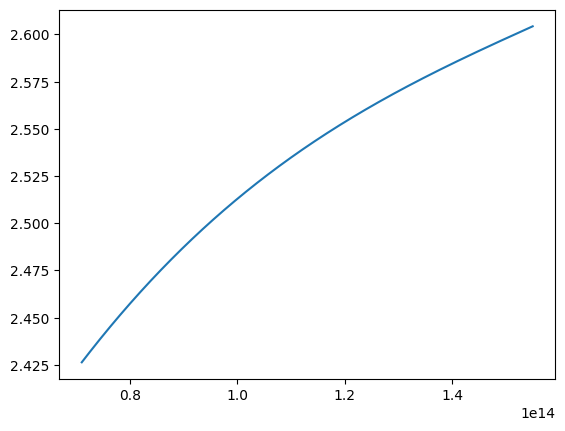

In [883]:
plt.plot(frequenz_s_cut,polynomial(frequenz_s_cut, *params_J14))

In [884]:
print(minima_frequenz_room[3:])
print(m_array_room_clean[3:])

[150191596641236.9, 138930840720343.62, 126875037898966.48, 115469727990716.27, 103283826544742.78, 91574953299018.11, 80343108193583.73]
[12 11 10  9  8  7]


In [885]:
print(minima_frequenz_90[2:])
print(m_array_90_clean[2:])

[149497737489931.94, 138439357157334.2, 126817216298027.83, 115469727990716.27, 103283826544742.78, 91820695065533.17, 79186676264749.05]
[12 11 10  9  8  7]


In [886]:
print(minima_frequenz_160)
print(m_array_160_clean)


[150393972229532.44, 138482723365532.98, 126918404077185.98, 115455272597976.42, 103283826544742.78, 91574953299018.11, 79952812409732.48]
[12 11 10  9  8  7]
